In [198]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.animation import FuncAnimation
r1, r2, r3, th1, th2, th3, phi1, phi2 = sp.symbols("r_1 r_2 r_3 theta_1 theta_2 theta_3 phi_1 phi_2")

In [167]:
get_z_rot_mat = lambda phi: sp.Matrix([[sp.cos(phi), -sp.sin(phi), 0],
                                       [sp.sin(phi), sp.cos(phi), 0],
                                       [0, 0, 1]])

get_y_rot_mat = lambda th: sp.Matrix([[sp.cos(th), 0, sp.sin(th)],
                                      [0, 1, 0],
                                      [-sp.sin(th), 0, sp.cos(th)]])

get_x_rot_mat = lambda th: sp.Matrix([[1, 0, 0],
                                      [0, sp.cos(th), -sp.sin(th)],
                                      [0, sp.sin(th), sp.cos(th)]])

In [168]:
def plot_vector(v):
    r = np.linalg.norm(v)
    xline = [0, v[0]]
    yline = [0, v[1]]
    zline = [0, v[2]]
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(-r,r)
    ax.set_ylim(-r,r)
    ax.set_zlim(-r,r)
    ax.plot3D(xline, yline, zline)
    ax.scatter(0, 0, 0, marker='s')
    ax.scatter(*v)


# Get cartesian motor positions from motor angle values

$\theta_1$ and $\phi_1$ show the inclination and azimuth of armature 1 from the z-axis.
$\theta_2$ shows the inclination of armature 2 from armature 1.
$\theta_3$  and $\phi_2$ shows the inclination and azimuth of armature 2 from armature 1.

## arm 1

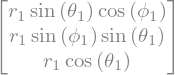

In [169]:
dX1 = sp.Matrix([r1*sp.sin(th1)*sp.cos(phi1),
                 r1*sp.sin(th1)*sp.sin(phi1),
                 r1*sp.cos(th1)])

lam_dX1 = sp.lambdify([r1, th1, phi1], dX1, "numpy")
dX1

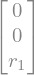

In [170]:
sp.trigsimp((get_y_rot_mat(-th1) * get_z_rot_mat(-phi1)) * dX1)

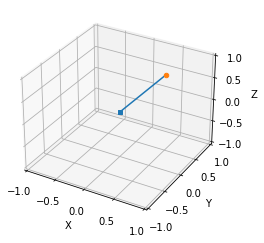

In [177]:
plot_vector(lam_dX1(1, np.pi/4, np.pi/4))

## arm 2

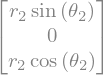

In [172]:
dX2p = sp.Matrix([r2*sp.sin(th2),
                  0,
                  r2*sp.cos(th2)]); dX2p


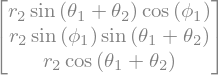

In [178]:
dX2 = sp.trigsimp((get_y_rot_mat(-th1) * get_z_rot_mat(-phi1)).inv() * dX2p)

lam_dX2 = sp.lambdify([r1, r2, th1, th2, phi1], dX2, "numpy")
dX2

## arm 3

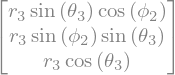

In [174]:
dX3p = sp.Matrix([r3*sp.sin(th3)*sp.cos(phi2),
                  r3*sp.sin(th3)*sp.sin(phi2),
                  r3*sp.cos(th3)]); dX3p

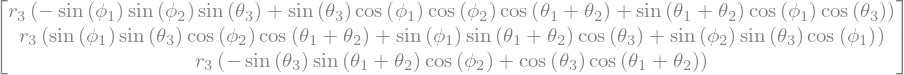

In [179]:
dX3 = sp.trigsimp((get_y_rot_mat(-(th1+th2)) * get_z_rot_mat(-phi1)).inv() * dX3p)

lam_dX3 = sp.lambdify([r1, r2, r3, th1, th2, th3, phi1, phi2], dX3, "numpy")
dX3

# get list of x points, y points & z points for animation

In [225]:
def arm_coords(th1, th2, th3, phi1, phi2, r1=1, r2=1, r3=1):
    # get change in position of each arm
    arm_1_coords = lam_dX1(r1, th1, phi1)[:,0,:].T
    d_arm_2_coords = lam_dX2(r1, r2, th1, th2, phi1)[:,0,:].T
    d_arm_3_coords = lam_dX3(r1, r2, r3, th1, th2, th3, phi1, phi2)[:,0,:].T

    # get absolute position of each arm
    arm_2_coords = arm_1_coords + d_arm_2_coords
    arm_3_coords = arm_2_coords + d_arm_3_coords

    # format output for animation
    x_points = np.array([np.zeros(len(th1)), arm_1_coords[:, 0], arm_2_coords[:, 0], arm_3_coords[:, 0]]).T
    y_points = np.array([np.zeros(len(th1)), arm_1_coords[:, 1], arm_2_coords[:, 1], arm_3_coords[:, 1]]).T
    z_points = np.array([np.zeros(len(th1)), arm_1_coords[:, 2], arm_2_coords[:, 2], arm_3_coords[:, 2]]).T

    return x_points, y_points, z_points


### RUN ###
th1 = th2 = th3 = phi1 = phi2 = np.zeros(20)
th1 = th2 = th3 = np.linspace(np.pi/4, np.pi/4, 20)
phi1 = np.zeros(20) + np.pi/2
th1 = th2 = np.linspace(0, np.pi/3, 20)

phi2 = np.linspace(np.pi/2, np.pi/2, 20)
x_points, y_points, z_points = arm_coords(th1, th2, th3, phi1, phi2)

# create animation

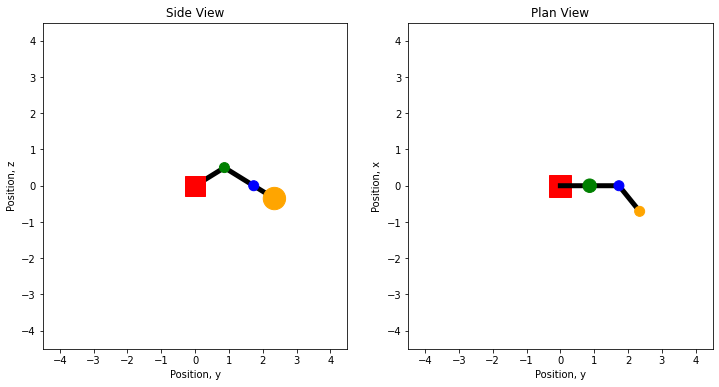

In [226]:
def animate_5dof(x_points, y_points, z_points, thAs=None, thBs=None, thCs=None):
    if not (thAs is None or thBs is None or thCs is None):
        big_plot = True
        thAs, thBs, thCs = thAs*180/np.pi, thBs*180/np.pi, thCs*180/np.pi
    else:
        big_plot=False

    # get bounds for marker sizes
    size_bounds_x = [np.min(np.min(x_points, axis=1)).round(5), np.max(np.max(x_points, axis=1)).round(5)]
    size_bounds_z = [np.min(np.min(z_points, axis=1)).round(5), np.max(np.max(z_points, axis=1)).round(5)]
    size_bounds_y = [np.min(np.min(y_points, axis=1)).round(5), np.max(np.max(y_points, axis=1)).round(5)]


    # the animation
    if big_plot:
        fig = plt.figure(figsize=(12, 12))
        ax1 = plt.subplot(2,2,1)
        ax2 = plt.subplot(2,2,2)
        ax3 = plt.subplot(2,1,2)

        ax3.set_xlim([0, len(thAs)])
        ax3.set_ylim([np.min([np.min(thCs), np.min(thAs), np.min(thBs)]), np.max([np.max(thCs), np.max(thAs), np.max(thBs)])])
        ax3.plot(thAs[:1], label="$\\theta_a$")
        ax3.plot(thBs[:1], label="$\\theta_b$")
        ax3.plot(thCs[:1], label="$\\theta_c$")
        ax3.legend()
        ax3.set_title("Motor Angles")
        ax3.set_xlabel("Time")
        ax3.set_ylabel("Motor Angle (degrees)")
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    def construct_frame(i):
        xpoints = x_points[i,:]
        ypoints = y_points[i,:]
        zpoints = z_points[i,:]

        # Side on view of the robot
        ax1.clear()
        ax1.set_xlim([-4.5, 4.5])
        ax1.set_ylim([-4.5, 4.5])
        ax1.plot(ypoints, zpoints, linewidth=5, color="black", zorder=1)
        ax1.plot(0, 0, 's', markersize=20, color="red", zorder=2)
        ax1.scatter(x=ypoints[1:], y=zpoints[1:], s=np.interp(xpoints[1:], size_bounds_x, [500, 100]), c=["green", "blue", "orange"], zorder=3)
        ax1.set_xlabel("Position, y")
        ax1.set_ylabel("Position, z")
        ax1.set_title("Side View")

        # top down view of the robot
        ax2.clear()
        ax2.set_xlim([-4.5, 4.5])
        ax2.set_ylim([-4.5, 4.5])
        ax2.plot(ypoints, xpoints, linewidth=5, color="black", zorder=2)
        ax2.plot(0, 0, marker=(4, 0, 45-(180/np.pi)*np.arctan2(ypoints[1], xpoints[1])), markersize=30, color="red", zorder=1)
        ax2.scatter(x=ypoints[1:], y=xpoints[1:], s=np.interp(zpoints[1:], size_bounds_y, [100, 500]), c=["green", "blue", "orange"], zorder=3)
        ax2.set_title("Plan View")
        ax2.set_xlabel("Position, y")
        ax2.set_ylabel("Position, x")

        if big_plot:
            # log of motor positions
            ax3.plot(thAs[:i], label="$\\theta_a$", color="blue")
            ax3.plot(thBs[:i], label="$\\theta_b$", color="orange")
            ax3.plot(thCs[:i], label="$\\theta_c$", color="green")

    # set ani variable to call the
    # function recursively
    anim = FuncAnimation(fig, construct_frame, interval=1, frames=len(x_points[:,1]))
    anim.save("out.mp4", fps=24, dpi=200)

animate_5dof(x_points, y_points, z_points)